# # Gesture Recognition Model Training
# 
# This notebook trains and compares different models for gesture recognition using accelerometer and gyroscope data.

In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [2]:
# TensorFlow/Keras imports for LSTM
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

print("TensorFlow version:", tf.__version__)

c:\Users\aditya\Documents\PROJECTS\sensor-data-classification\github\mpu6050-activity-classifier\.venv\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\aditya\Documents\PROJECTS\sensor-data-classification\github\mpu6050-activity-classifier\.venv\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\aditya\Documents\PROJECTS\sensor-data-classification\github\mpu6050-activity-classifier\.venv\Lib\site-packages\google\protobuf\runtime_version.p

TensorFlow version: 2.20.0-rc0


In [3]:
# ====== Step 1: Load and preprocess data ======
base_dir = "data"  # top-level data directory
all_data = []

for gesture in os.listdir(base_dir):
    gesture_path = os.path.join(base_dir, gesture)
    if not os.path.isdir(gesture_path):
        continue  # skip non-directories

    for file in os.listdir(gesture_path):
        if file.endswith(".csv"):
            file_path = os.path.join(gesture_path, file)
            df = pd.read_csv(file_path, names=["acx", "acy", "acz", "gyx", "gyy", "gyz"])
            # remove first and last row. There are decent chances these 2 lines are gibberish or missing data.
            df = df.iloc[1:-1].reset_index(drop=True)
            df["label"] = gesture  # add gesture label column
            all_data.append(df)

# Merge all into one DataFrame
data = pd.concat(all_data, ignore_index=True)

# Strip whitespace from columns and ensure numeric dtype
data.columns = data.columns.str.strip()
for col in ["acx", "acy", "acz", "gyx", "gyy", "gyz"]:
    data[col] = pd.to_numeric(data[col], errors="coerce")

print("Data shape:", data.shape)
print("Gestures:", data["label"].unique())
print("Data info:")
print(data.info())

Data shape: (22124, 7)
Gestures: ['idle_noise' 'rear_hook' 'rear_uppercut' 'wave']
Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22124 entries, 0 to 22123
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   acx     22124 non-null  float64
 1   acy     22124 non-null  float64
 2   acz     22124 non-null  float64
 3   gyx     22124 non-null  float64
 4   gyy     22124 non-null  float64
 5   gyz     22124 non-null  float64
 6   label   22124 non-null  object 
dtypes: float64(6), object(1)
memory usage: 1.2+ MB
None


C:\Users\aditya\AppData\Local\Temp\ipykernel_14360\1235344332.py:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data = pd.concat(all_data, ignore_index=True)


In [4]:
# ====== Step 2: Feature Engineering for Random Forest ======
def create_windows(df, window_size=50, overlap=0):
    """Create statistical features from sliding windows"""
    X, y = [], []
    step = window_size - overlap
    
    for i in range(0, len(df) - window_size + 1, step):
        window = df.iloc[i:i+window_size]
        features = []
        
        # Statistical features for each sensor
        for col in ["acx", "acy", "acz", "gyx", "gyy", "gyz"]:
            features += [
                window[col].mean(),
                window[col].std(),
                window[col].min(),
                window[col].max(),
                window[col].max() - window[col].min(),  # range
                np.percentile(window[col], 25),  # Q1
                np.percentile(window[col], 75),  # Q3
                window[col].skew(),  # skewness
                window[col].kurtosis()  # kurtosis
            ]
        
        # Cross-sensor features
        acc_magnitude = np.sqrt(window["acx"]**2 + window["acy"]**2 + window["acz"]**2)
        gyro_magnitude = np.sqrt(window["gyx"]**2 + window["gyy"]**2 + window["gyz"]**2)
        
        features += [
            acc_magnitude.mean(),
            acc_magnitude.std(),
            gyro_magnitude.mean(),
            gyro_magnitude.std(),
            np.corrcoef(window["acx"], window["acy"])[0,1],  # correlation between acx and acy
            np.corrcoef(window["gyx"], window["gyy"])[0,1]   # correlation between gyx and gyy
        ]
        
        X.append(features)
        y.append(window["label"].iloc[0])
    
    return X, y

In [5]:
# Apply windowing per gesture recording
print("Creating windows with statistical features...")
X_all, y_all = [], []
for gesture in data["label"].unique():
    subset = data[data["label"] == gesture]
    X, y = create_windows(subset, window_size=50, overlap=25)
    X_all.extend(X)
    y_all.extend(y)

X_all = np.array(X_all)
y_all = np.array(y_all)

print(f"Feature matrix shape: {X_all.shape}")
print(f"Labels shape: {y_all.shape}")

Creating windows with statistical features...


c:\Users\aditya\Documents\PROJECTS\sensor-data-classification\github\mpu6050-activity-classifier\.venv\Lib\site-packages\numpy\lib\_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\aditya\Documents\PROJECTS\sensor-data-classification\github\mpu6050-activity-classifier\.venv\Lib\site-packages\numpy\lib\_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Feature matrix shape: (879, 60)
Labels shape: (879,)


In [6]:
# ====== Step 3: Random Forest Model ======
print("=== TRAINING RANDOM FOREST MODEL ===")

# Train/test split for RF
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(
    X_all, y_all, test_size=0.2, random_state=42, stratify=y_all
)

=== TRAINING RANDOM FOREST MODEL ===


In [9]:
# Scale features
scaler = StandardScaler()
X_train_rf_scaled = scaler.fit_transform(X_train_rf)
X_test_rf_scaled = scaler.transform(X_test_rf)

In [10]:
# Train Random Forest
rf_clf = RandomForestClassifier(
    n_estimators=200, 
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)
rf_clf.fit(X_train_rf_scaled, y_train_rf)

,n_estimators,200
,criterion,'gini'
,max_depth,15
,min_samples_split,5
,min_samples_leaf,2
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [11]:
# Evaluate Random Forest
y_pred_rf = rf_clf.predict(X_test_rf_scaled)
rf_accuracy = accuracy_score(y_test_rf, y_pred_rf)

print(f"Random Forest Accuracy: {rf_accuracy:.4f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test_rf, y_pred_rf))
print("\nClassification Report:")
print(classification_report(y_test_rf, y_pred_rf))

Random Forest Accuracy: 0.9489

Confusion Matrix:
[[59  0  0  0]
 [ 4 56  0  1]
 [ 0  2 39  1]
 [ 0  1  0 13]]

Classification Report:
               precision    recall  f1-score   support

   idle_noise       0.94      1.00      0.97        59
    rear_hook       0.95      0.92      0.93        61
rear_uppercut       1.00      0.93      0.96        42
         wave       0.87      0.93      0.90        14

     accuracy                           0.95       176
    macro avg       0.94      0.94      0.94       176
 weighted avg       0.95      0.95      0.95       176



In [12]:
# Feature importance analysis
feature_names = []
for col in ["acx", "acy", "acz", "gyx", "gyy", "gyz"]:
    feature_names += [f"{col}_mean", f"{col}_std", f"{col}_min", f"{col}_max", 
                     f"{col}_range", f"{col}_q25", f"{col}_q75", f"{col}_skew", f"{col}_kurt"]
feature_names += ["acc_mag_mean", "acc_mag_std", "gyro_mag_mean", "gyro_mag_std", 
                 "acc_corr_xy", "gyro_corr_xy"]

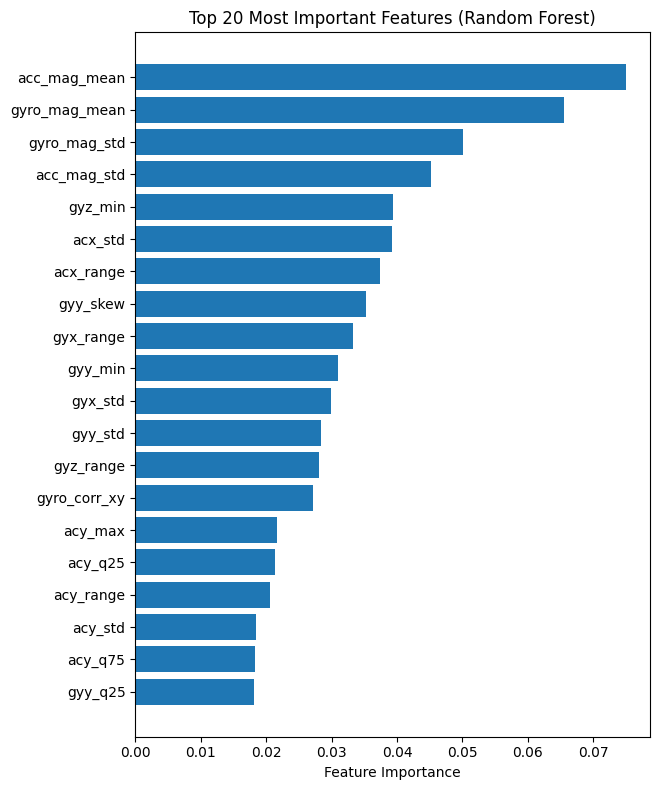

In [13]:
# Plot feature importance
plt.figure(figsize=(12, 8))
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': rf_clf.feature_importances_
}).sort_values('importance', ascending=True)

plt.subplot(1, 2, 1)
top_20_features = feature_importance.tail(20)
plt.barh(range(len(top_20_features)), top_20_features['importance'])
plt.yticks(range(len(top_20_features)), top_20_features['feature'])
plt.xlabel('Feature Importance')
plt.title('Top 20 Most Important Features (Random Forest)')
plt.tight_layout()

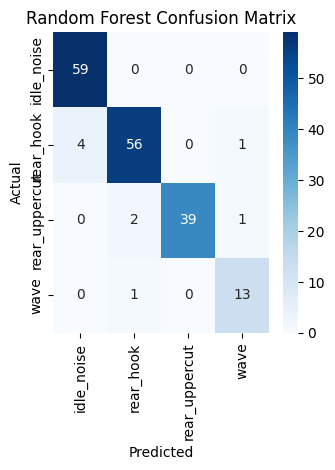

In [14]:
# Confusion matrix heatmap
plt.subplot(1, 2, 2)
cm_rf = confusion_matrix(y_test_rf, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', 
            xticklabels=rf_clf.classes_, yticklabels=rf_clf.classes_)
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

In [15]:
# Save Random Forest model
print("Saving Random Forest model...")
joblib.dump(rf_clf, "random_forest_model.pkl")
joblib.dump(scaler, "feature_scaler.pkl")

Saving Random Forest model...


['feature_scaler.pkl']

In [16]:
# ====== Step 4: Prepare data for LSTM (Sequential approach) ======
print("=== PREPARING DATA FOR LSTM MODEL ===")

def create_sequence_windows(df, window_size=50, overlap=25):
    """Create sequential windows for LSTM"""
    step = window_size - overlap
    X, y = [], []
    
    for i in range(0, len(df) - window_size + 1, step):
        window = df.iloc[i:i+window_size]
        X.append(window[["acx", "acy", "acz", "gyx", "gyy", "gyz"]].values)
        y.append(window["label"].iloc[0])
    
    return X, y

# Create sequence data for LSTM
all_sequences = []
all_seq_labels = []

for gesture in os.listdir(base_dir):
    gesture_path = os.path.join(base_dir, gesture)
    if not os.path.isdir(gesture_path):
        continue
        
    for file in os.listdir(gesture_path):
        if file.endswith(".csv"):
            file_path = os.path.join(gesture_path, file)
            df = pd.read_csv(file_path, names=["acx", "acy", "acz", "gyx", "gyy", "gyz"])
            df = df.iloc[1:-1].reset_index(drop=True)
            df["label"] = gesture
            
            # Ensure numeric data
            for col in ["acx", "acy", "acz", "gyx", "gyy", "gyz"]:
                df[col] = pd.to_numeric(df[col], errors="coerce")
            
            X_seq, y_seq = create_sequence_windows(df, window_size=50, overlap=25)
            all_sequences.extend(X_seq)
            all_seq_labels.extend(y_seq)

X_sequences = np.array(all_sequences, dtype=np.float32)  # shape: (samples, 50, 6)
y_sequences = np.array(all_seq_labels)

print(f"Sequence data shape: {X_sequences.shape}")
print(f"Sequence labels shape: {y_sequences.shape}")

=== PREPARING DATA FOR LSTM MODEL ===
Sequence data shape: (869, 50, 6)
Sequence labels shape: (869,)


In [17]:
# ====== Step 5: Encode labels for LSTM ======
le = LabelEncoder()
y_sequences_enc = le.fit_transform(y_sequences)
y_sequences_cat = to_categorical(y_sequences_enc)
num_classes = len(le.classes_)

print(f"Number of classes: {num_classes}")
print(f"Classes: {le.classes_}")

# Train/test split for LSTM
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(
    X_sequences, y_sequences_cat, test_size=0.2, random_state=42, 
    stratify=y_sequences_enc
)

print(f"LSTM training data shape: {X_train_lstm.shape}")
print(f"LSTM test data shape: {X_test_lstm.shape}")

Number of classes: 4
Classes: ['idle_noise' 'rear_hook' 'rear_uppercut' 'wave']
LSTM training data shape: (695, 50, 6)
LSTM test data shape: (174, 50, 6)


In [18]:
# ====== Step 6: Build and train LSTM model ======
print("=== BUILDING LSTM MODEL ===")

# Build LSTM model
lstm_model = Sequential([
    LSTM(128, input_shape=(X_sequences.shape[1], X_sequences.shape[2]), 
         return_sequences=True, dropout=0.2, recurrent_dropout=0.2),
    LSTM(64, return_sequences=False, dropout=0.2, recurrent_dropout=0.2),
    Dense(50, activation='relu'),
    Dropout(0.3),
    Dense(25, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile model
lstm_model.compile(
    loss='categorical_crossentropy', 
    optimizer=Adam(learning_rate=0.001), 
    metrics=['accuracy']
)

print("LSTM Model Summary:")
lstm_model.summary()

# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_accuracy', 
    patience=10, 
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5, 
    patience=5, 
    min_lr=0.0001,
    verbose=1
)


=== BUILDING LSTM MODEL ===
LSTM Model Summary:


c:\Users\aditya\Documents\PROJECTS\sensor-data-classification\github\mpu6050-activity-classifier\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50, 128)        │        69,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50)             │         3,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           104 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 123,157 (481.08 KB)

 Trainable params: 123,157 (481.08 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# ====== Step 7: Train LSTM model ======
print("=== TRAINING LSTM MODEL ===")

history = lstm_model.fit(
    X_train_lstm, y_train_lstm,
    validation_data=(X_test_lstm, y_test_lstm),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

=== TRAINING LSTM MODEL ===
Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 13s 269ms/step - accuracy: 0.4518 - loss: 1.2249 - val_accuracy: 0.6264 - val_loss: 1.0649 - learning_rate: 0.0010
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 150ms/step - accuracy: 0.5856 - loss: 1.0274 - val_accuracy: 0.7011 - val_loss: 0.8439 - learning_rate: 0.0010
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 0.6633 - loss: 0.8410 - val_accuracy: 0.7644 - val_loss: 0.7003 - learning_rate: 0.0010
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 0.7396 - loss: 0.6935 - val_accuracy: 0.8276 - val_loss: 0.5550 - learning_rate: 0.0010
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 0.7597 - loss: 0.6224 - val_accuracy: 0.8161 - val_loss: 0.5217 - learning_rate: 0.0010
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 0.8144 - loss: 0.5190 - val_accuracy: 0.8391 - val_loss: 0.4260 - learning_rate: 0.0010
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 107ms/step - accur

In [20]:
# ====== Step 8: Evaluate LSTM model ======
print("=== EVALUATING LSTM MODEL ===")

# Evaluate on test set
lstm_loss, lstm_accuracy = lstm_model.evaluate(X_test_lstm, y_test_lstm, verbose=0)
print(f"LSTM Test Accuracy: {lstm_accuracy:.4f}")

# Make predictions
y_pred_lstm_proba = lstm_model.predict(X_test_lstm)
y_pred_lstm = np.argmax(y_pred_lstm_proba, axis=1)
y_test_lstm_labels = np.argmax(y_test_lstm, axis=1)

# Convert back to gesture names for confusion matrix
y_test_gesture_names = le.inverse_transform(y_test_lstm_labels)
y_pred_gesture_names = le.inverse_transform(y_pred_lstm)

print("\nLSTM Confusion Matrix:")
print(confusion_matrix(y_test_gesture_names, y_pred_gesture_names))
print("\nLSTM Classification Report:")
print(classification_report(y_test_gesture_names, y_pred_gesture_names))


=== EVALUATING LSTM MODEL ===
LSTM Test Accuracy: 0.9195
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 257ms/step

LSTM Confusion Matrix:
[[56  0  0  3]
 [ 2 58  0  0]
 [ 0  1 41  0]
 [ 7  1  0  5]]

LSTM Classification Report:
               precision    recall  f1-score   support

   idle_noise       0.86      0.95      0.90        59
    rear_hook       0.97      0.97      0.97        60
rear_uppercut       1.00      0.98      0.99        42
         wave       0.62      0.38      0.48        13

     accuracy                           0.92       174
    macro avg       0.86      0.82      0.83       174
 weighted avg       0.91      0.92      0.91       174



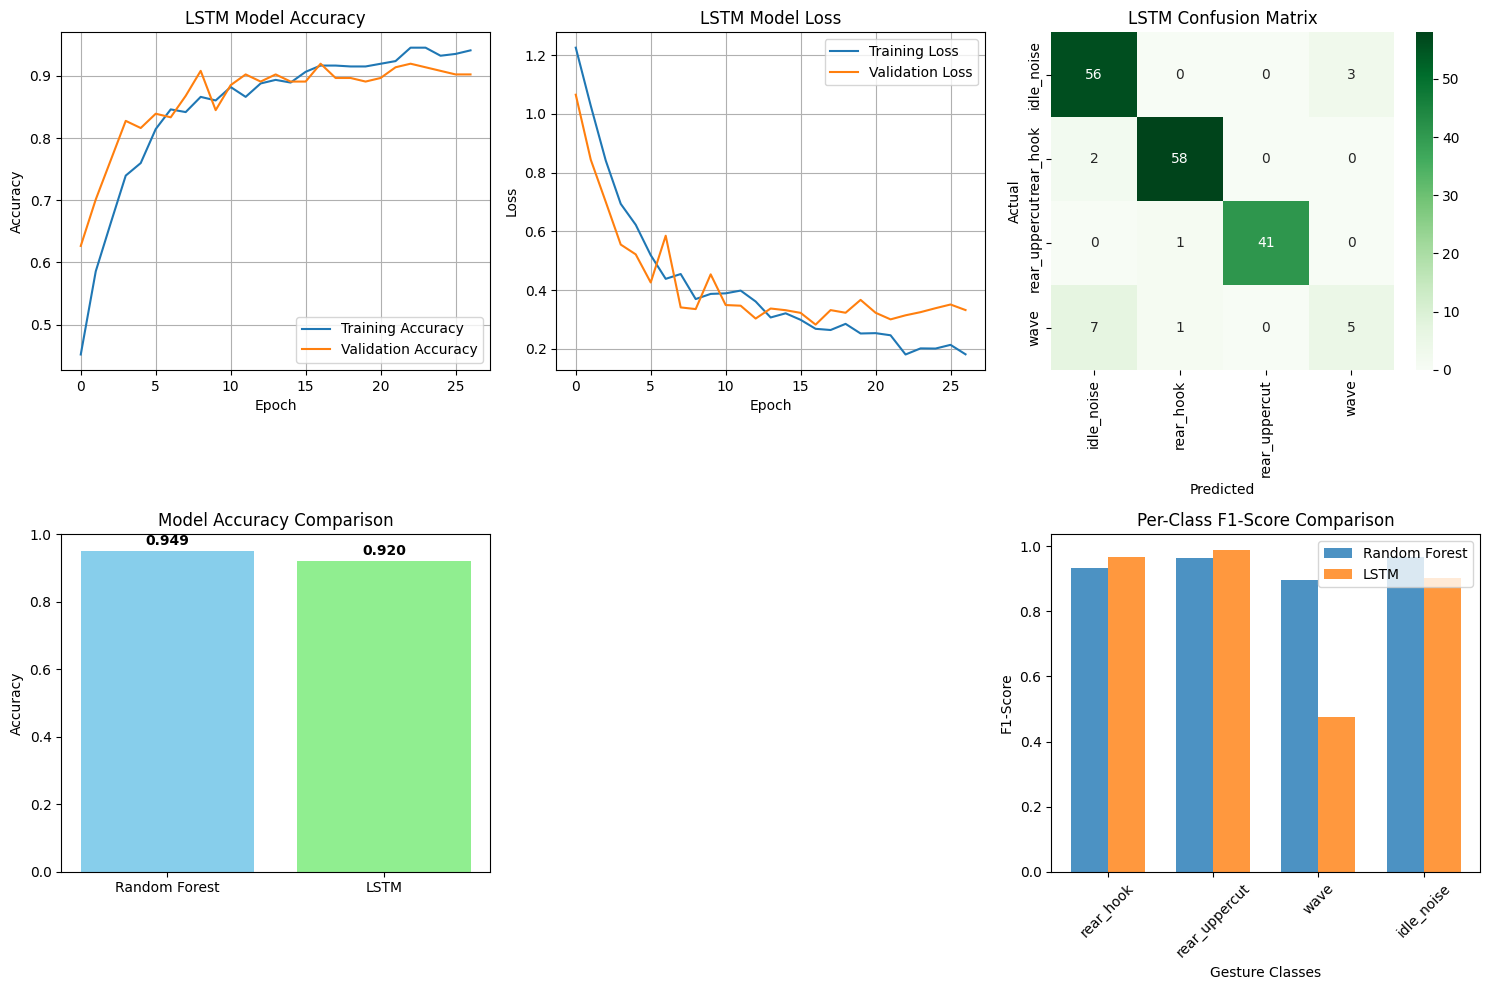

In [21]:
# ====== Step 9: Visualize training history and results ======
plt.figure(figsize=(15, 10))

# Training history
plt.subplot(2, 3, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('LSTM Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(2, 3, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Confusion matrices comparison
plt.subplot(2, 3, 3)
cm_lstm = confusion_matrix(y_test_gesture_names, y_pred_gesture_names)
sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('LSTM Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Model comparison
plt.subplot(2, 3, 4)
models = ['Random Forest', 'LSTM']
accuracies = [rf_accuracy, lstm_accuracy]
colors = ['skyblue', 'lightgreen']
bars = plt.bar(models, accuracies, color=colors)
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1)

# Add accuracy values on bars
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')

# Learning rate schedule
if 'lr' in history.history:
    plt.subplot(2, 3, 5)
    plt.plot(history.history['lr'])
    plt.title('Learning Rate Schedule')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.yscale('log')

# Per-class accuracy comparison
plt.subplot(2, 3, 6)
# Calculate per-class accuracy for both models
rf_report = classification_report(y_test_rf, y_pred_rf, output_dict=True)
lstm_report = classification_report(y_test_gesture_names, y_pred_gesture_names, output_dict=True)

classes = list(set(rf_report.keys()) & set(lstm_report.keys()) - {'accuracy', 'macro avg', 'weighted avg'})
rf_class_acc = [rf_report[cls]['f1-score'] for cls in classes]
lstm_class_acc = [lstm_report[cls]['f1-score'] for cls in classes]

x = np.arange(len(classes))
width = 0.35

plt.bar(x - width/2, rf_class_acc, width, label='Random Forest', alpha=0.8)
plt.bar(x + width/2, lstm_class_acc, width, label='LSTM', alpha=0.8)

plt.xlabel('Gesture Classes')
plt.ylabel('F1-Score')
plt.title('Per-Class F1-Score Comparison')
plt.xticks(x, classes, rotation=45)
plt.legend()

plt.tight_layout()
plt.show()


In [22]:
# ====== Step 10: Build and train 1D CNN model ======
print("=== BUILDING 1D CNN MODEL ===")

# Build 1D CNN model
cnn_model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', 
           input_shape=(X_sequences.shape[1], X_sequences.shape[2])),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    Flatten(),
    Dense(100, activation='relu'),
    Dropout(0.3),
    Dense(50, activation='relu'),
    Dense(num_classes, activation='softmax')
])

cnn_model.compile(
    loss='categorical_crossentropy', 
    optimizer=Adam(learning_rate=0.001), 
    metrics=['accuracy']
)

print("CNN Model Summary:")
cnn_model.summary()


=== BUILDING 1D CNN MODEL ===
CNN Model Summary:


c:\Users\aditya\Documents\PROJECTS\sensor-data-classification\github\mpu6050-activity-classifier\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 48, 64)         │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 22, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 11, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 9, 64)          │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 100)            │        57,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           204 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 113,514 (443.41 KB)

 Trainable params: 113,514 (443.41 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
# Train CNN model
print("Training 1D CNN model...")
cnn_history = cnn_model.fit(
    X_train_lstm, y_train_lstm,
    validation_data=(X_test_lstm, y_test_lstm),
    epochs=30,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)


Training 1D CNN model...
Epoch 1/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.5137 - loss: 1.2630 - val_accuracy: 0.6552 - val_loss: 0.9026 - learning_rate: 0.0010
Epoch 2/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.6705 - loss: 0.7732 - val_accuracy: 0.6839 - val_loss: 0.7552 - learning_rate: 0.0010
Epoch 3/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.7640 - loss: 0.6031 - val_accuracy: 0.7759 - val_loss: 0.6537 - learning_rate: 0.0010
Epoch 4/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8201 - loss: 0.4994 - val_accuracy: 0.7989 - val_loss: 0.5470 - learning_rate: 0.0010
Epoch 5/30
15/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8457 - loss: 0.4300
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8417 - loss: 0.4237 - val_accuracy: 0.8161 - val_loss: 0.5158 - learning_rate: 0.0010
Epoch 6/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8676 -

In [24]:
# Evaluate CNN model
cnn_loss, cnn_accuracy = cnn_model.evaluate(X_test_lstm, y_test_lstm, verbose=0)
print(f"CNN Test Accuracy: {cnn_accuracy:.4f}")

CNN Test Accuracy: 0.6552


In [25]:
# ====== Step 11: Hybrid CNN-LSTM model ======
print("=== BUILDING HYBRID CNN-LSTM MODEL ===")

hybrid_model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', 
           input_shape=(X_sequences.shape[1], X_sequences.shape[2])),
    Conv1D(filters=32, kernel_size=3, activation='relu'),
    LSTM(50, dropout=0.2, recurrent_dropout=0.2),
    Dense(25, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

hybrid_model.compile(
    loss='categorical_crossentropy', 
    optimizer=Adam(learning_rate=0.001), 
    metrics=['accuracy']
)

print("Hybrid CNN-LSTM Model Summary:")
hybrid_model.summary()


=== BUILDING HYBRID CNN-LSTM MODEL ===
Hybrid CNN-LSTM Model Summary:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 48, 64)         │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 46, 32)         │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        16,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │           104 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,371 (99.11 KB)

 Trainable params: 25,371 (99.11 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
# Train hybrid model
print("Training hybrid CNN-LSTM model...")
hybrid_history = hybrid_model.fit(
    X_train_lstm, y_train_lstm,
    validation_data=(X_test_lstm, y_test_lstm),
    epochs=30,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)


Training hybrid CNN-LSTM model...
Epoch 1/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.5568 - loss: 1.0490 - val_accuracy: 0.5862 - val_loss: 0.9499 - learning_rate: 2.5000e-04
Epoch 2/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.5799 - loss: 1.0254 - val_accuracy: 0.5920 - val_loss: 0.9107 - learning_rate: 2.5000e-04
Epoch 3/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.5741 - loss: 1.0031 - val_accuracy: 0.6034 - val_loss: 0.8704 - learning_rate: 2.5000e-04
Epoch 4/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.6374 - loss: 0.9541 - val_accuracy: 0.6494 - val_loss: 0.8342 - learning_rate: 2.5000e-04
Epoch 5/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.6367 - loss: 0.9243
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.6273 - loss: 0.9292 - val_accuracy: 0.6782 - val_loss: 0.8014 - learning_rate: 2.5000e-04
Epoch 6/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 

In [28]:
# Evaluate hybrid model
hybrid_loss, hybrid_accuracy = hybrid_model.evaluate(X_test_lstm, y_test_lstm, verbose=0)
print(f"Hybrid CNN-LSTM Test Accuracy: {hybrid_accuracy:.4f}")


Hybrid CNN-LSTM Test Accuracy: 0.5862


=== FINAL MODEL COMPARISON ===
Final Model Accuracies:
Random Forest: 0.9489
LSTM: 0.9195
1D CNN: 0.6552
CNN-LSTM Hybrid: 0.5862

Best Model: Random Forest with accuracy: 0.9489


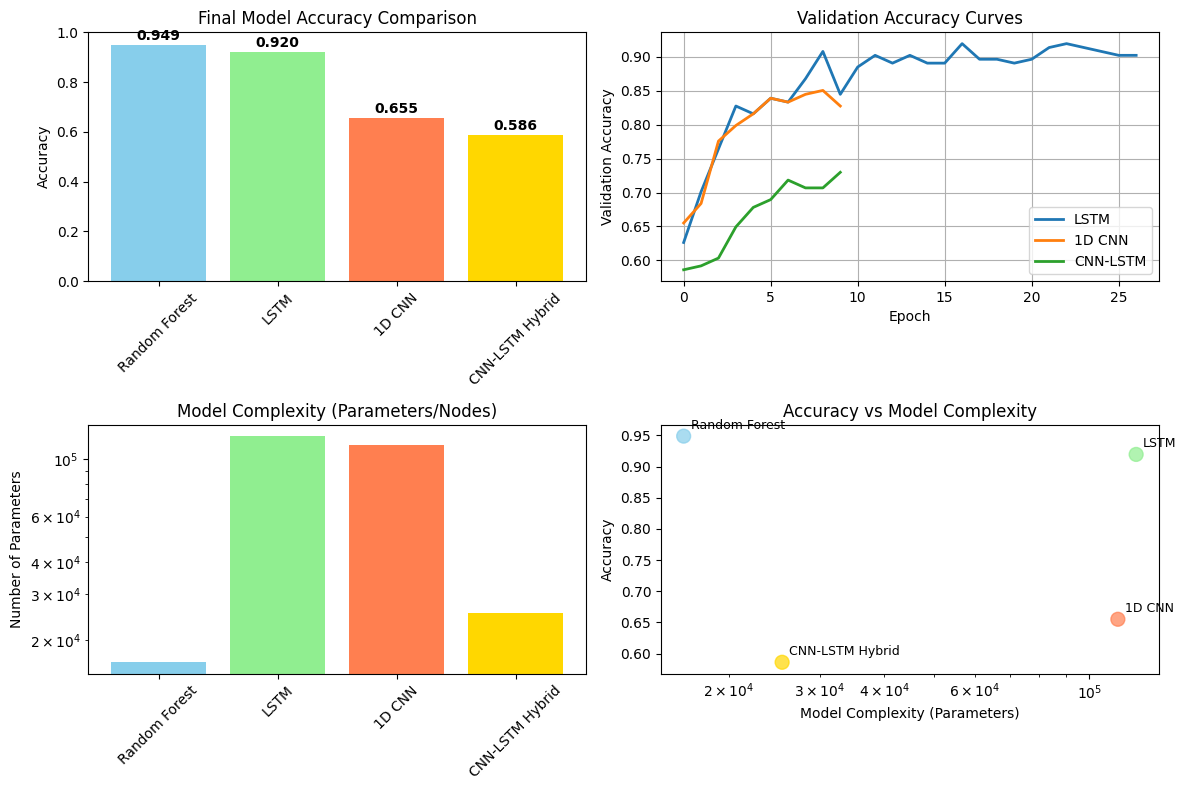

In [29]:
# ====== Step 12: Final model comparison and selection ======
print("=== FINAL MODEL COMPARISON ===")

# Compare all models
model_results = {
    'Random Forest': rf_accuracy,
    'LSTM': lstm_accuracy,
    '1D CNN': cnn_accuracy,
    'CNN-LSTM Hybrid': hybrid_accuracy
}

print("Final Model Accuracies:")
for model, accuracy in model_results.items():
    print(f"{model}: {accuracy:.4f}")

# Select best model
best_model_name = max(model_results, key=model_results.get)
best_accuracy = model_results[best_model_name]

print(f"\nBest Model: {best_model_name} with accuracy: {best_accuracy:.4f}")

# Visualization of final comparison
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
models = list(model_results.keys())
accuracies = list(model_results.values())
colors = ['skyblue', 'lightgreen', 'coral', 'gold']
bars = plt.bar(models, accuracies, color=colors)
plt.title('Final Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.xticks(rotation=45)

# Add accuracy values on bars
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')

# Training curves comparison for deep learning models
plt.subplot(2, 2, 2)
plt.plot(history.history['val_accuracy'], label='LSTM', linewidth=2)
plt.plot(cnn_history.history['val_accuracy'], label='1D CNN', linewidth=2)
plt.plot(hybrid_history.history['val_accuracy'], label='CNN-LSTM', linewidth=2)
plt.title('Validation Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.grid(True)

# Model complexity comparison
plt.subplot(2, 2, 3)
model_params = {
    'Random Forest': sum(tree.tree_.node_count for tree in rf_clf.estimators_),
    'LSTM': lstm_model.count_params(),
    '1D CNN': cnn_model.count_params(),
    'CNN-LSTM Hybrid': hybrid_model.count_params()
}

models_complex = list(model_params.keys())
params = list(model_params.values())
plt.bar(models_complex, params, color=colors)
plt.title('Model Complexity (Parameters/Nodes)')
plt.ylabel('Number of Parameters')
plt.yscale('log')
plt.xticks(rotation=45)

# Performance vs Complexity scatter
plt.subplot(2, 2, 4)
plt.scatter([model_params[model] for model in models], 
           [model_results[model] for model in models], 
           c=colors, s=100, alpha=0.7)

for i, model in enumerate(models):
    plt.annotate(model, 
                (model_params[model], model_results[model]),
                xytext=(5, 5), textcoords='offset points', fontsize=9)

plt.xlabel('Model Complexity (Parameters)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Model Complexity')
plt.xscale('log')

plt.tight_layout()
plt.show()


In [30]:
# ====== Step 13: Save best models ======
print("=== SAVING MODELS ===")

# Save all deep learning models
lstm_model.save("lstm_model.keras")
cnn_model.save("cnn_model.keras")
hybrid_model.save("hybrid_cnn_lstm_model.keras")

# Save label encoder
joblib.dump(le, "label_encoder.pkl")

print(f"Models saved successfully!")
print(f"Random Forest: random_forest_model.pkl")
print(f"LSTM: lstm_model.keras")
print(f"CNN: cnn_model.keras")
print(f"Hybrid: hybrid_cnn_lstm_model.keras")
print(f"Label Encoder: label_encoder.pkl")
print(f"Feature Scaler: feature_scaler.pkl")

# ====== Step 14: Model inference example ======
print("=== MODEL INFERENCE EXAMPLE ===")

# Example of how to use the saved models for prediction
def predict_with_rf(X_sample):
    """Predict using Random Forest model"""
    rf_model = joblib.load("random_forest_model.pkl")
    scaler = joblib.load("feature_scaler.pkl")
    X_scaled = scaler.transform(X_sample)
    return rf_model.predict(X_scaled)

def predict_with_lstm(X_sequence):
    """Predict using LSTM model"""
    from tensorflow.keras.models import load_model
    lstm = load_model("lstm_model.keras")
    le = joblib.load("label_encoder.pkl")
    predictions = lstm.predict(X_sequence)
    predicted_classes = np.argmax(predictions, axis=1)
    return le.inverse_transform(predicted_classes)

print("Inference functions created.")
print("Example usage:")
print("  RF prediction: predict_with_rf(feature_array)")
print("  LSTM prediction: predict_with_lstm(sequence_array)")

# ====== Step 15: Summary and recommendations ======
print("=== TRAINING SUMMARY ===")
print(f"✓ Trained 4 different models on gesture recognition task")
print(f"✓ Best performing model: {best_model_name} ({best_accuracy:.4f} accuracy)")
print(f"✓ Random Forest: Good baseline with interpretable features")
print(f"✓ LSTM: Captures temporal dependencies in gesture sequences")
print(f"✓ CNN: Learns local patterns in sensor data")
print(f"✓ Hybrid: Combines CNN feature extraction with LSTM temporal modeling")

print("\n=== RECOMMENDATIONS ===")
if best_model_name == 'Random Forest':
    print("• Random Forest performed best - the engineered statistical features are highly effective")
    print("• Consider ensemble methods combining RF with deep learning models")
    print("• Feature engineering was crucial - focus on domain-specific features")
elif 'LSTM' in best_model_name:
    print("• LSTM-based model performed best - temporal patterns are key for gesture recognition")
    print("• Consider data augmentation to improve generalization")
    print("• Experiment with bidirectional LSTM or attention mechanisms")
elif 'CNN' in best_model_name:
    print("• CNN performed best - local patterns in sensor data are discriminative")
    print("• Consider deeper CNN architectures or residual connections")
    print("• Multi-scale convolutions might capture different gesture dynamics")

print(f"\n• Model complexity varies significantly - choose based on deployment constraints")
print(f"• All models saved and ready for deployment")
print(f"• Consider ensemble methods for production use")


=== SAVING MODELS ===
Models saved successfully!
Random Forest: random_forest_model.pkl
LSTM: lstm_model.keras
CNN: cnn_model.keras
Hybrid: hybrid_cnn_lstm_model.keras
Label Encoder: label_encoder.pkl
Feature Scaler: feature_scaler.pkl
=== MODEL INFERENCE EXAMPLE ===
Inference functions created.
Example usage:
  RF prediction: predict_with_rf(feature_array)
  LSTM prediction: predict_with_lstm(sequence_array)
=== TRAINING SUMMARY ===
✓ Trained 4 different models on gesture recognition task
✓ Best performing model: Random Forest (0.9489 accuracy)
✓ Random Forest: Good baseline with interpretable features
✓ LSTM: Captures temporal dependencies in gesture sequences
✓ CNN: Learns local patterns in sensor data
✓ Hybrid: Combines CNN feature extraction with LSTM temporal modeling

=== RECOMMENDATIONS ===
• Random Forest performed best - the engineered statistical features are highly effective
• Consider ensemble methods combining RF with deep learning models
• Feature engineering was crucial